# PAN Style Analysis Task
exploring the training data

author: Deniz

date: February 2025

In [1]:
# imports
import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
import os
import json

## ensembling exploration

In [5]:
# overlap between the five models
models = ["all-MiniLM-L12-v2", "deberta-base", "roberta-base", "sentence-t5-base", "bge-base-en-v1.5"]

preds = []
print("total: 33654")
for i in range(len(models)):
 preds1 = np.load(f"{models[i]}_preds.npy")
 preds.append(preds1)
 for j in range(i+1, len(models)):
  preds2 = np.load(f"{models[j]}_preds.npy")
  overlap = sum(preds1 == preds2)
  print(f"{models[i]} v. {models[j]}: {overlap}")

total: 33654
all-MiniLM-L12-v2 v. deberta-base: 30736
all-MiniLM-L12-v2 v. roberta-base: 30754
all-MiniLM-L12-v2 v. sentence-t5-base: 30113
all-MiniLM-L12-v2 v. bge-base-en-v1.5: 30148
deberta-base v. roberta-base: 30668
deberta-base v. sentence-t5-base: 29959
deberta-base v. bge-base-en-v1.5: 30036
roberta-base v. sentence-t5-base: 30037
roberta-base v. bge-base-en-v1.5: 30058
sentence-t5-base v. bge-base-en-v1.5: 30651


In [11]:
# hard majority voting
import torch

all_preds = torch.stack([torch.from_numpy(p) for p in preds])  # Shape: (num_models, num_samples)
print([sum(p) for p in preds])
final_preds, _ = torch.mode(all_preds, dim=0) # majority voting
val_labels = np.load("val_labels.npy")
print(f"# of pos preds in ensemble {sum(final_preds)}")

[6123, 6489, 6281, 5378, 5397]
# of pos preds in ensemble 5323


## data exploration

In [4]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/db823/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
DATA_DIR = "data"

In [6]:
## read in data from dir with txt and json 
def read_labeled_data(dir):
  problems = [] # list of lists, each list is a problem and contains the list of sentences
  labels = []
  files = os.listdir(dir)
  files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
  for file in files:
    #print(file)
    with open(dir+"/"+file, "r") as f:
      if(file.endswith(".txt")):
        # a problem file
        problem = f.readlines()
        problems.append(problem)
      else:
        # a truth file
        truth = json.load(f)
        labels.append(truth)
  
  return problems, labels

In [ ]:
# parallel arrays, where labels[i] corresponds to probs[i]
train_easy_probs, train_easy_labels = read_labeled_data("data/easy/train")
train_med_probs, train_med_labels = read_labeled_data("data/medium/train")
train_hard_probs, train_hard_labels = read_labeled_data("data/hard/train")

In [13]:
# checking that they are parallel
assert len(train_easy_probs) == len(train_easy_labels)
for i in range(len(train_easy_probs)):
  prob = train_easy_probs[i]
  label = train_easy_labels[i]
  # print(f"prob: {prob}")
  # print(f"label: {label}")
  assert (len(prob)-1) == len(label['changes'])

## exploring training data characteristics

### author counts

In [5]:
## counting numbers of authors for easy vs. med. vs hard division
def get_author_counts(labels):
  author_counts = {}
  for label in labels:
    count = label['authors']
    author_counts[count] = author_counts.get(count, 0)+1

  return author_counts

In [14]:
# num. of authors evenly distributed across difficulty levels
easy_author_counts = get_author_counts(train_easy_labels)
med_author_counts = get_author_counts(train_med_labels)
hard_author_counts = get_author_counts(train_hard_labels)
print("author counts:")
print("easy", easy_author_counts)
print("med", med_author_counts)
print("hard", hard_author_counts)

author counts:
easy {2: 1400, 3: 1400, 4: 1400}
med {4: 1400, 3: 1400, 2: 1400}
hard {4: 1400, 3: 1400, 2: 1400}


### token lengths of sentences

In [15]:
# average number of sentences per problem
easy_num_sentences = sum([len(i) for i in train_easy_probs]) / len(train_easy_probs)
med_num_sentences = sum([len(i) for i in train_med_probs]) / len(train_med_probs)
hard_num_sentences = sum([len(i) for i in train_hard_probs]) / len(train_hard_probs)
print("avg number of sentences per data point:")
print("easy", easy_num_sentences)
print("med", med_num_sentences)
print("hard", hard_num_sentences)

avg number of sentences per data point:
easy 12.524285714285714
med 15.004047619047618
hard 13.157619047619047


In [16]:
# distribution of sentence length across easy dataset
easy_token_lengths = [len(word_tokenize(j)) for i in train_easy_probs for j in i]
med_token_lengths = [len(word_tokenize(j)) for i in train_med_probs for j in i]
hard_token_lengths = [len(word_tokenize(j)) for i in train_hard_probs for j in i]

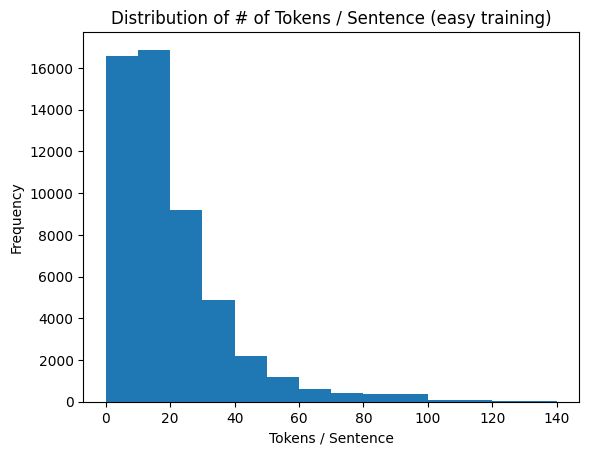

In [ ]:
plt.clf()
plt.hist(easy_token_lengths, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120, 130, 140])
plt.title("Distribution of # of Tokens / Sentence (easy training)")
plt.xlabel("Tokens / Sentence")
plt.ylabel("Frequency")
plt.show()

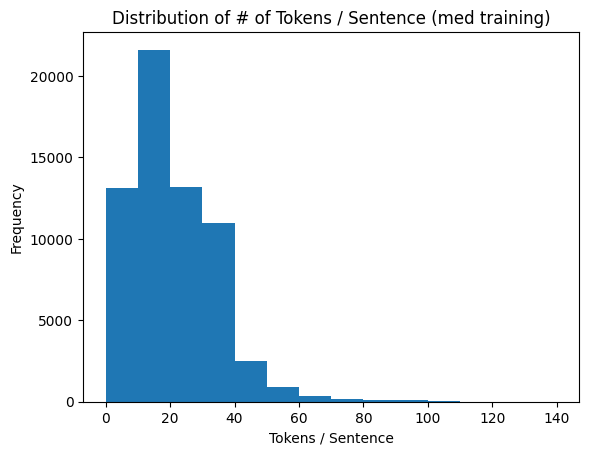

In [18]:
plt.clf()
plt.hist(med_token_lengths, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120, 130, 140])
plt.title("Distribution of # of Tokens / Sentence (med training)")
plt.xlabel("Tokens / Sentence")
plt.ylabel("Frequency")
plt.show()

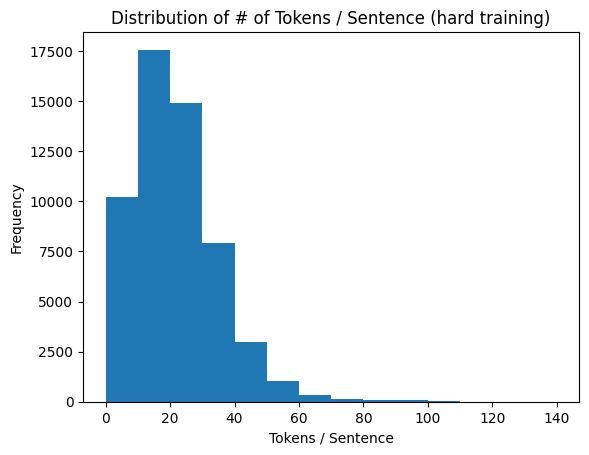

In [19]:
plt.clf()
plt.hist(hard_token_lengths, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120, 130, 140])
plt.title("Distribution of # of Tokens / Sentence (hard training)")
plt.xlabel("Tokens / Sentence")
plt.ylabel("Frequency")
plt.show()

### "label" characteristics

In [ ]:
# checking class imbalance in the data
sentence_pairs = 0
author_change_counts = 0

easy_diffs = 0
med_diffs = 0
hard_diffs = 0
assert len(train_easy_labels) == len(train_med_labels) == len(train_hard_labels) # size of the difficulty levels is the same
for x, y, z in zip(train_easy_labels, train_med_labels, train_hard_labels):
  easy_diffs += x['changes']
  med_diffs += y['changes']
  hard_diffs += z['changes']
  author_change_counts += sum(x['changes']) + sum(y['changes']) + sum(z['changes'])
  sentence_pairs += len(x['changes']) + len(y['changes']) + len(z['changes'])

print("training")
print(f"sentence pairs change authors {author_change_counts}, {100*author_change_counts/sentence_pairs}%")
print(f"# of sentence pairs {sentence_pairs}")

sentence pairs change authors 31542, 19.92797573919636%
# of sentence pairs 158280


In [10]:
# parallel arrays, where labels[i] corresponds to probs[i]
val_easy_probs, val_easy_labels = read_labeled_data("data/easy/validation")
val_med_probs, val_med_labels = read_labeled_data("data/medium/validation")
val_hard_probs, val_hard_labels = read_labeled_data("data/hard/validation")

In [11]:
# checking class imbalance in the data
sentence_pairs = 0
author_change_counts = 0
assert len(val_easy_labels) == len(val_med_labels) == len(val_hard_labels) # size of the difficulty levels is the same
for x, y, z in zip(val_easy_labels, val_med_labels, val_hard_labels):
  author_change_counts += sum(x['changes']) + sum(y['changes']) + sum(z['changes'])
  sentence_pairs += len(x['changes']) + len(y['changes']) + len(z['changes'])

print("validation!")
print(f"sentence pairs change authors {author_change_counts}, {100*author_change_counts/sentence_pairs}%")
print(f"# of sentence pairs {sentence_pairs}")

validation!
sentence pairs change authors 6857, 20.37499257146253%
# of sentence pairs 33654


In [5]:
preds_simcse = np.load("unsup-simcse-roberta-base_preds.npy")
print("style change preds (val)", sum(preds_simcse))

style change preds (val) 5046


In [6]:
preds_minilm = np.load("all-MiniLM-L12-v2_preds.npy")
print("style change preds (val)", sum(preds_minilm))

style change preds (val) 4807


In [9]:
# compare output from all-minilm and simcse embeddings
print(f"agree on {sum(preds_simcse == preds_minilm)}/{len(preds_simcse)}")

agree on 30547/33654


In [7]:
train_labels = np.load("train_labels.npy")
print(f"og {len(train_labels)}")
print(sum(train_labels))

bal_labels = np.load("train_bal_labels.npy")
print(f"total len: {len(bal_labels)}")
# print(f"{type(bal_labels[0])}")
print(f"{sum(bal_labels)}")

og 158268
31541
total len: 253454
126727


In [ ]:
# see whether the num of authors is always equal to the number of (author changes + 1)
# nope! same author can come back later in the document
diff_changes = 0
for x, y, z in zip(train_easy_labels, train_med_labels, train_hard_labels):
  if sum(x['changes']) > x['authors']:
    diff_changes += 1
  if sum(y['changes']) > y['authors']:
    diff_changes += 1
  if sum(z['changes']) > z['authors']:
    diff_changes += 1
  
print(diff_changes)
print(len(train_easy_labels))

1427
4200
